<a href="https://colab.research.google.com/github/siv4gurunathan/trading_journal/blob/main/benchmark_with_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.3 MB/s eta 0:00:00


/tmp/ipython-input-1146767022.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index_data = yf.download(symbol, start=start_date, progress=False)
/tmp/ipython-input-1146767022.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index_data = yf.download(symbol, start=start_date, progress=False)
/tmp/ipython-input-1146767022.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index_data = yf.download(symbol, start=start_date, progress=False)
/tmp/ipython-input-1146767022.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(df["ticker"].tolist(), start=start_date, progress=False)["Close"]
/tmp/ipython-input-1146767022.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(df["ticker"].tolist(), start=start_date, progress=False)["Close"]
2025-10-19 08:08:56.428 WARNING streamli

DeltaGenerator()

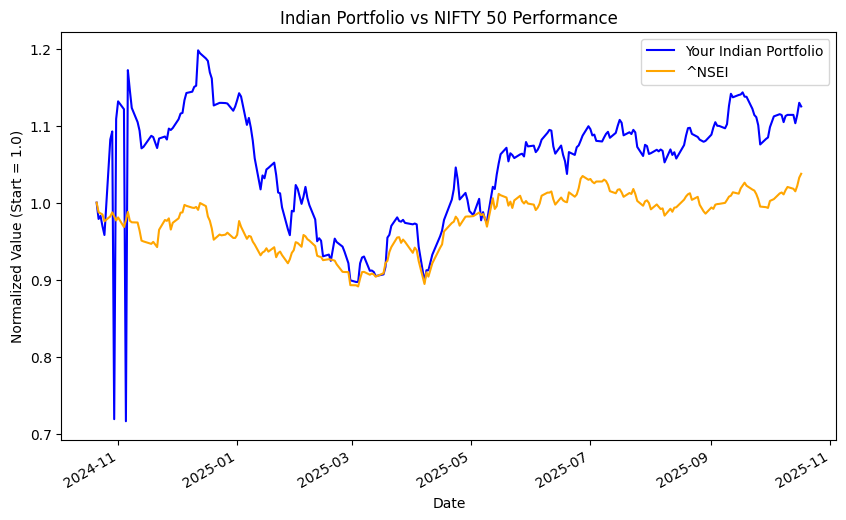

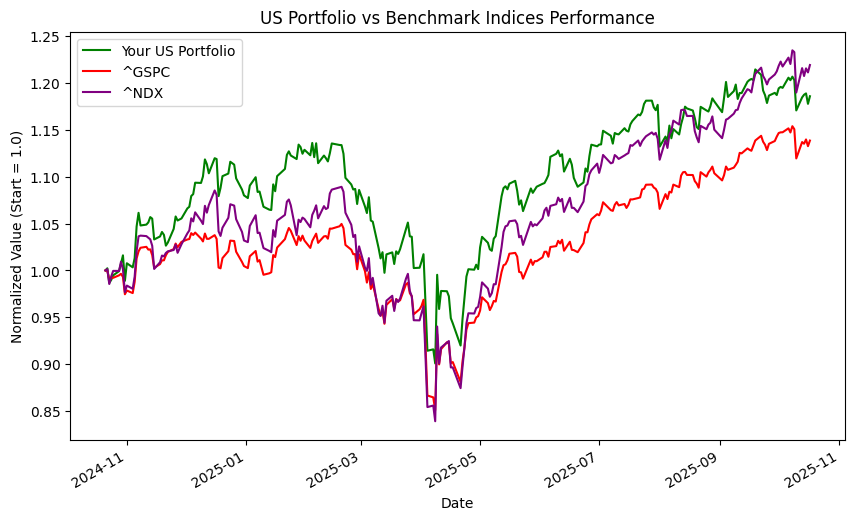

In [2]:
!pip install streamlit
import streamlit as st
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt

# Load CSV data
df_in = pd.read_csv("indian_portfolio.csv")
df_us = pd.read_csv("us_portfolio.csv")

# Function to get current price
def get_price(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(period="1d")
    if 'Close' in data.columns and not data['Close'].empty:
        return data['Close'].iloc[-1]
    else:
        return float('nan')

# Process portfolio
def process_portfolio(df):
    df["current_price"] = df["ticker"].apply(get_price)
    df["total_value"] = df["quantity"] * df["current_price"]
    df["invested"] = df["quantity"] * df["buy_price"]
    df["pnl"] = df["total_value"] - df["invested"]
    df["return_%"] = (df["pnl"] / df["invested"]) * 100
    total_value = df["total_value"].sum()
    df["allocation_%"] = (df["total_value"] / total_value) * 100
    return df

# Fetch index data from yfinance
def fetch_index_data(symbol, start_date):
    index_data = yf.download(symbol, start=start_date, progress=False)
    index_data = index_data["Close"]
    return index_data / index_data.iloc[0]  # Normalize for comparison

# Process portfolios
df_in = process_portfolio(df_in)
df_us = process_portfolio(df_us)

# Calculate portfolio daily values using tickers (weighted)
def get_portfolio_index(df, start_date):
    prices = yf.download(df["ticker"].tolist(), start=start_date, progress=False)["Close"]
    portfolio_value = prices * df.set_index("ticker")["quantity"]
    portfolio_total = portfolio_value.sum(axis=1)
    return portfolio_total / portfolio_total.iloc[0]

# Define date range (1 year back)
end = dt.datetime.today()
start = end - dt.timedelta(days=365)

# Get index performance
nifty = fetch_index_data("^NSEI", start)
sp500 = fetch_index_data("^GSPC", start)
nasdaq = fetch_index_data("^NDX", start)

# Get portfolio normalized performance
indian_portfolio_perf = get_portfolio_index(df_in, start)
us_portfolio_perf = get_portfolio_index(df_us, start)

# Start Streamlit Dashboard
st.title("📊 Portfolio vs Index Performance Comparison")

# Indian Portfolio Section
st.header("🇮🇳 Indian Portfolio vs NIFTY 50")
st.dataframe(df_in)

fig1, ax1 = plt.subplots(figsize=(10, 6))
indian_portfolio_perf.plot(ax=ax1, label="Your Indian Portfolio", color="blue")
nifty.plot(ax=ax1, label="NIFTY 50 Index", color="orange")
ax1.set_title("Indian Portfolio vs NIFTY 50 Performance")
ax1.set_ylabel("Normalized Value (Start = 1.0)")
ax1.legend()
st.pyplot(fig1)

# US Portfolio Section
st.header("🇺🇸 US Portfolio vs S&P 500 & NASDAQ 100")
st.dataframe(df_us)

fig2, ax2 = plt.subplots(figsize=(10, 6))
us_portfolio_perf.plot(ax=ax2, label="Your US Portfolio", color="green")
sp500.plot(ax=ax2, label="S&P 500 Index", color="red")
nasdaq.plot(ax=ax2, label="NASDAQ 100 Index", color="purple")
ax2.set_title("US Portfolio vs Benchmark Indices Performance")
ax2.set_ylabel("Normalized Value (Start = 1.0)")
ax2.legend()
st.pyplot(fig2)

# Show key metrics
st.subheader("Indian Portfolio Overall Performance")
st.metric("Total Invested", f"${df_in['invested'].sum():,.2f}")
st.metric("Portfolio Value", f"${df_in['total_value'].sum():,.2f}")
st.metric("Total P&L", f"${df_in['pnl'].sum():,.2f}", delta=f"{(df_in['pnl'].sum() / df_in['invested'].sum()) * 100:.2f}%")

st.subheader("US Portfolio Overall Performance")
st.metric("Total Invested", f"${df_us['invested'].sum():,.2f}")
st.metric("Portfolio Value", f"${df_us['total_value'].sum():,.2f}")
st.metric("Total P&L", f"${df_us['pnl'].sum():,.2f}", delta=f"{(df_us['pnl'].sum() / df_us['invested'].sum()) * 100:.2f}%")

st.caption("Data Source: Yahoo Finance | Charts normalized to start = 1 for yearly comparison.")
